In [1]:
!pip install prophet


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prophet.diagnostics import cross_validation, performance_metrics

In [3]:
# Imported Fact Order dataset
factOrder_df = pd.read_csv('FactOrder.csv')


# Find number of rows and columns of the dataset
print(factOrder_df.shape)

(525854, 13)


In [4]:
factOrder_df

,OrderNumber,OrderRowNumber,ArticleKey,Colour,ArticleGenre,Size,ArticleGroupName,Collection,SizeGroup,BabyJunior,ArticleMaterial,DateOrderedKey,QuantityOrdered
0,94940600,11,36200,red,SHIRT/BLOUSE,92/98,TOPS,Pre,4[92-98],2 TODDLER,SHIRT LS,20180121,1.0
1,94940600,12,12030,Blue,DENIM,92/98,BOTTOMS,Pre,4[92-98],2 TODDLER,NaN,20180121,1.0
2,94940600,13,7354,offwhite,TEES LS,92/98,TOPS,Pre,4[92-98],2 TODDLER,RIB,20180121,1.0
3,94940800,1,8501,offwhite,DRESSES LS,116/122,DRESSES,Main,6[116-122],3 KIDS,NaN,20180121,1.0
4,94940800,2,24256,offwhite,LEGGINGS,104/110,BOTTOMS,Main,5[104-110],3 KIDS,NaN,20180121,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525849,115372400,1,35335,Beige,BEANIES,52/54,HATS,Base,XHATS,3 KIDS,JERSEY,20201217,2.0
525850,115372500,1,53305,Purple,KNITTED HATS,52/54,HATS,Main,XHATS,3 KIDS,EAR HAT,20201217,1.0
525851,115372500,2,19068,Beige,DRESSES SS,92/98,DRESSES,Main,4[92-98],2 TODDLER,JERSEY,20201217,1.0
525852,115372700,1,42059,Beige,TEES SS,92/98,TOPS,Base,4[92-98],2 TODDLER,JERSEY,20201217,1.0


In [5]:
# Get column datatypes and check for null values
factOrder_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525854 entries, 0 to 525853
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   OrderNumber       525854 non-null  int64  
 1   OrderRowNumber    525854 non-null  int64  
 2   ArticleKey        525854 non-null  int64  
 3   Colour            525387 non-null  object 
 4   ArticleGenre      525854 non-null  object 
 5   Size              525387 non-null  object 
 6   ArticleGroupName  525854 non-null  object 
 7   Collection        525854 non-null  object 
 8   SizeGroup         520329 non-null  object 
 9   BabyJunior        520329 non-null  object 
 10  ArticleMaterial   412090 non-null  object 
 11  DateOrderedKey    525854 non-null  int64  
 12  QuantityOrdered   525854 non-null  float64
dtypes: float64(1), int64(4), object(8)
memory usage: 52.2+ MB


In [6]:
# Check for null values
factOrder_df.isnull().sum()

OrderNumber              0
OrderRowNumber           0
ArticleKey               0
Colour                 467
ArticleGenre             0
Size                   467
ArticleGroupName         0
Collection               0
SizeGroup             5525
BabyJunior            5525
ArticleMaterial     113764
DateOrderedKey           0
QuantityOrdered          0
dtype: int64

In [7]:
# Check for duplicates
factOrder_df_dup = factOrder_df[factOrder_df.duplicated(keep='first')]
factOrder_df_dup

,OrderNumber,OrderRowNumber,ArticleKey,Colour,ArticleGenre,Size,ArticleGroupName,Collection,SizeGroup,BabyJunior,ArticleMaterial,DateOrderedKey,QuantityOrdered


In [8]:
factOrder_df.describe()

,OrderNumber,OrderRowNumber,ArticleKey,DateOrderedKey,QuantityOrdered
count,5.258540e+05,525854.000000,525854.000000,5.258540e+05,525854.000000
mean,1.053578e+08,3.018788,28728.222387,2.019319e+07,1.033945
std,6.088081e+06,3.562329,16414.319554,8.067215e+03,0.237343
min,9.449840e+07,1.000000,2.000000,2.018010e+07,1.000000
25%,1.001611e+08,1.000000,14537.000000,2.019012e+07,1.000000
50%,1.058498e+08,2.000000,28983.000000,2.019123e+07,1.000000
75%,1.104078e+08,4.000000,43020.000000,2.020060e+07,1.000000
max,1.159414e+08,180.000000,57297.000000,2.021010e+07,21.000000


In [9]:
train_end_year = '2019'
article_dimension = 'ArticleGroupName' # 'ArticleGenre' 'ArticleGroupName' 'ArticleKey' 'Colour' 'BabyJunior' 'ArticleMaterial' 'Size' 'Collection' 'SizeGroup'

#factOrder_df = factOrder_df[(factOrder_df['QuantityOrdered'] >= 0) & (factOrder_df['QuantityOrdered'] <= 100)]
#factOrder_df = factOrder_df[factOrder_df['QuantityOrdered'] >=0]
#factOrder_df['QuantityOrdered'] = factOrder_df['QuantityOrdered'] / abs(factOrder_df['QuantityOrdered'])

In [10]:
factOrder_df['DateOrderedKey'] = factOrder_df['DateOrderedKey'].astype(str)
factOrder_df['DateOrderedKey'] = pd.to_datetime(factOrder_df['DateOrderedKey'])
factOrder_df['DateOrderedKey'] = factOrder_df['DateOrderedKey'].dt.strftime('%Y-%m')

#factOrder_df = factOrder_df.drop('DateOrderedKey', axis=1)
factOrder_df

,OrderNumber,OrderRowNumber,ArticleKey,Colour,ArticleGenre,Size,ArticleGroupName,Collection,SizeGroup,BabyJunior,ArticleMaterial,DateOrderedKey,QuantityOrdered
0,94940600,11,36200,red,SHIRT/BLOUSE,92/98,TOPS,Pre,4[92-98],2 TODDLER,SHIRT LS,2018-01,1.0
1,94940600,12,12030,Blue,DENIM,92/98,BOTTOMS,Pre,4[92-98],2 TODDLER,NaN,2018-01,1.0
2,94940600,13,7354,offwhite,TEES LS,92/98,TOPS,Pre,4[92-98],2 TODDLER,RIB,2018-01,1.0
3,94940800,1,8501,offwhite,DRESSES LS,116/122,DRESSES,Main,6[116-122],3 KIDS,NaN,2018-01,1.0
4,94940800,2,24256,offwhite,LEGGINGS,104/110,BOTTOMS,Main,5[104-110],3 KIDS,NaN,2018-01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
525849,115372400,1,35335,Beige,BEANIES,52/54,HATS,Base,XHATS,3 KIDS,JERSEY,2020-12,2.0
525850,115372500,1,53305,Purple,KNITTED HATS,52/54,HATS,Main,XHATS,3 KIDS,EAR HAT,2020-12,1.0
525851,115372500,2,19068,Beige,DRESSES SS,92/98,DRESSES,Main,4[92-98],2 TODDLER,JERSEY,2020-12,1.0
525852,115372700,1,42059,Beige,TEES SS,92/98,TOPS,Base,4[92-98],2 TODDLER,JERSEY,2020-12,1.0


In [11]:
#factOrder_df.DateOrderedKey =  pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m-%d')
#factOrder_df = factOrder_df[pd.to_datetime(factOrder_df['DateOrderedKey']).dt.strftime('%Y') >= '2020']

#total_by_date = factOrder_df.groupby(pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m'))['QuantityOrdered'].sum().fillna(0)
#total_by_date.plot()
#plt.title('Total Quantity by Date')
#plt.xlabel('Month')
#plt.ylabel('Total Quantity')
#plt.show()

# Preprocessing the dataset

In [12]:
article_dimension_df = pd.DataFrame(factOrder_df[article_dimension].dropna().unique(), columns=[article_dimension])
article_dimension_df = article_dimension_df.drop(article_dimension_df.index[9:])
article_dimension_df

,ArticleGroupName
0,TOPS
1,BOTTOMS
2,DRESSES
3,OUTERWEAR
4,HATS
5,BODY AND ONESIE
6,HOME
7,ACCESSORIES
8,SWIMWEAR


In [13]:
factOrder_df = article_dimension_df.merge(factOrder_df, how="inner", on=article_dimension)
factOrder_df.shape

(519720, 13)

In [14]:
#factOrder_df = factOrder_df.groupby(['DateOrderedKey']).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.groupby(['DateOrderedKey', article_dimension]).sum('QuantityOrdered').fillna(0)
factOrder_df = factOrder_df.reset_index()
factOrder_df = factOrder_df[['DateOrderedKey', 'QuantityOrdered', article_dimension]]

factOrder_df

,DateOrderedKey,QuantityOrdered,ArticleGroupName
0,2018-01,256.0,ACCESSORIES
1,2018-01,1074.0,BODY AND ONESIE
2,2018-01,6144.0,BOTTOMS
3,2018-01,2958.0,DRESSES
4,2018-01,1133.0,HATS
...,...,...,...
327,2021-01,23.0,DRESSES
328,2021-01,37.0,HATS
329,2021-01,139.0,OUTERWEAR
330,2021-01,4.0,SWIMWEAR


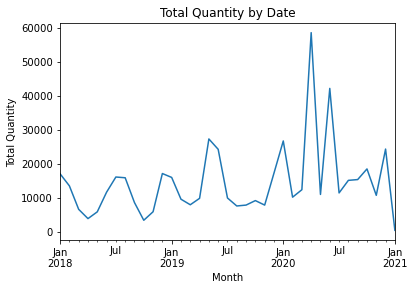

In [15]:
factOrder_df.DateOrderedKey =  pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m-%d')
#factOrder_df = factOrder_df[pd.to_datetime(factOrder_df['DateOrderedKey']).dt.strftime('%Y') >= '2020']

total_by_date = factOrder_df.groupby(pd.to_datetime(factOrder_df['DateOrderedKey'], format= '%Y-%m'))['QuantityOrdered'].sum().fillna(0)
total_by_date.plot()
plt.title('Total Quantity by Date')
plt.xlabel('Month')
plt.ylabel('Total Quantity')
plt.show()

In [16]:
# Creating the common function for splitting the dataset into test and train samples
def CreateSplitTestAndTrainData(df_model):
    # Splitting the dataset into training and test    
    #train = df_model[(pd.to_datetime(df_model['ds']).dt.strftime('%Y-%m') <= '2020-09' )] # | (pd.to_datetime(df_model['ds']).dt.strftime('%m') <= '6')]
    #test = df_model[(pd.to_datetime(df_model['ds']).dt.strftime('%Y-%m') > '2020-09')] # & (pd.to_datetime(df_model['ds']).dt.strftime('%m') > '6')]
        
    train = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') <= train_end_year] # | (pd.to_datetime(df_model['ds']).dt.strftime('%m') <= '6')]
    test = df_model[pd.to_datetime(df_model['ds']).dt.strftime('%Y') > train_end_year] # & (pd.to_datetime(df_model['ds']).dt.strftime('%m') > '6')]
    
    return train, test

In [17]:
def CreateModel(train):
    
    model = Prophet(weekly_seasonality=False, interval_width=0.95)
    #model = Prophet()
    
    # Enable monthly seasonality
    model.add_seasonality(name='monthly', period=365, fourier_order=5)
       
    # Fitting the model with the training dataset
    model.fit(train)
    
    return model

In [18]:
def ModelPrediction(model, _article_dimension):
    # Create future dates for prediction
    future_dates = model.make_future_dataframe(periods=12, freq='MS')
  #  future_dates = model.make_future_dataframe(periods=365, freq='D')

    # Make predictions for future dates
    predictions = model.predict(future_dates)

    # Plot the prediction
    model.plot(predictions);
    
    y_pred = predictions['yhat'].values

# plot expected vs actual
#pyplot.plot(y_true, label='Actual')

        
    plt.title(_article_dimension)
    plt.xlabel('Month')
    plt.ylabel('Quantity Ordered')
    #plt.xticks(rotation = 90)
    actual_data = df_model.groupby(df_model['ds'])['y'].sum().fillna(0).reset_index()
    plt.plot(actual_data['ds'], actual_data['y'], color = 'red', label='Actual')
    plt.legend(loc='upper right')
    plt.show()
    #print(predictions)
    
    
    return predictions
    
    # Plot the prediction components
   # model.plot_components(predictions);

TOPS


11:43:26 - cmdstanpy - INFO - Chain [1] start processing
11:43:27 - cmdstanpy - INFO - Chain [1] done processing


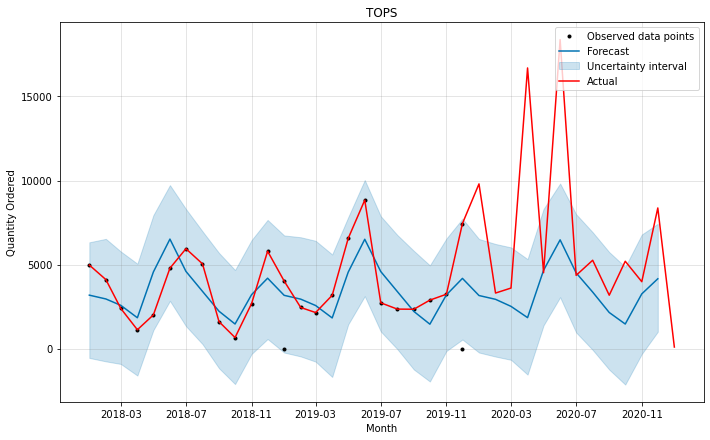

11:43:28 - cmdstanpy - INFO - Chain [1] start processing


BOTTOMS


11:43:28 - cmdstanpy - INFO - Chain [1] done processing


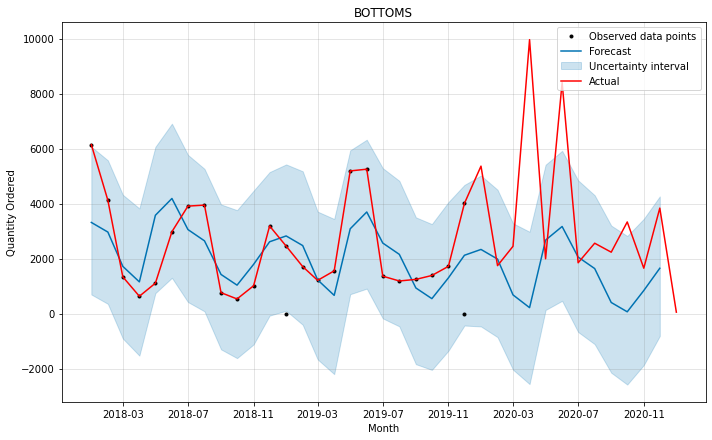

DRESSES


11:43:30 - cmdstanpy - INFO - Chain [1] start processing
11:43:30 - cmdstanpy - INFO - Chain [1] done processing


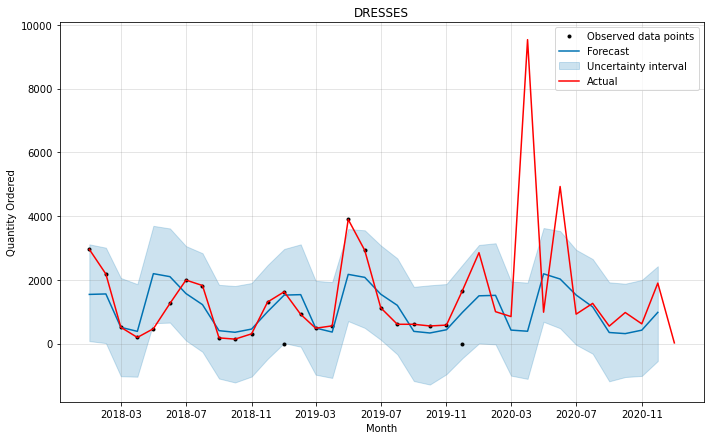

OUTERWEAR


11:43:31 - cmdstanpy - INFO - Chain [1] start processing
11:43:31 - cmdstanpy - INFO - Chain [1] done processing


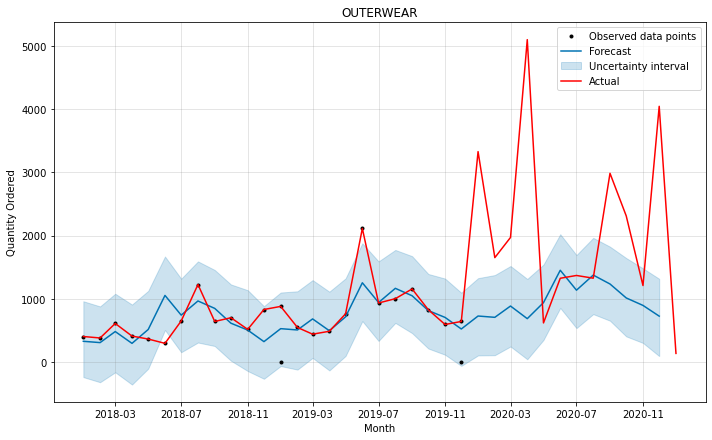

11:43:32 - cmdstanpy - INFO - Chain [1] start processing


HATS


11:43:32 - cmdstanpy - INFO - Chain [1] done processing


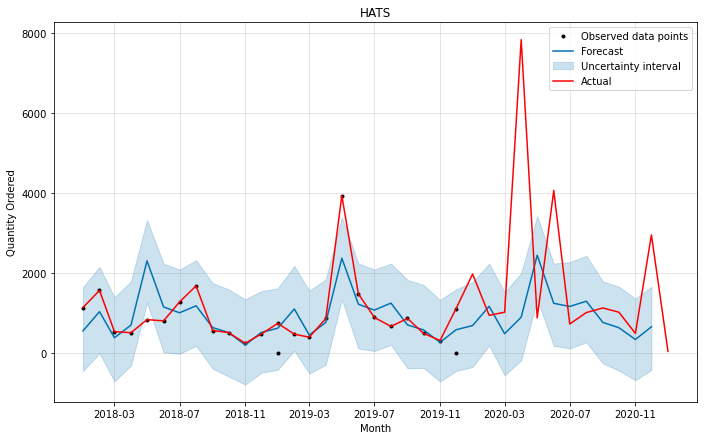

11:43:33 - cmdstanpy - INFO - Chain [1] start processing


BODY AND ONESIE


11:43:33 - cmdstanpy - INFO - Chain [1] done processing


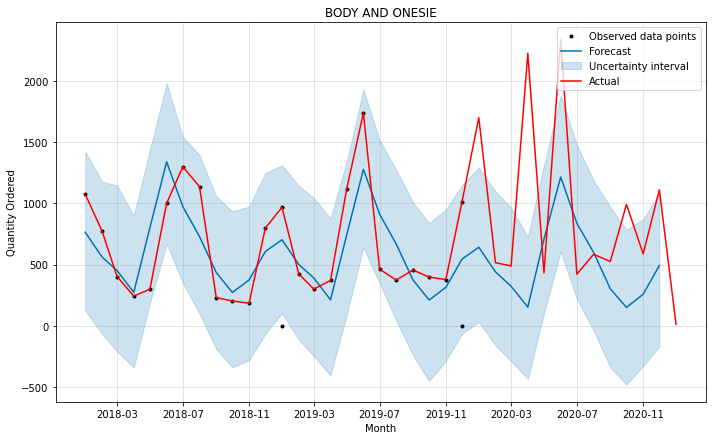

HOME


11:43:35 - cmdstanpy - INFO - Chain [1] start processing
11:43:35 - cmdstanpy - INFO - Chain [1] done processing


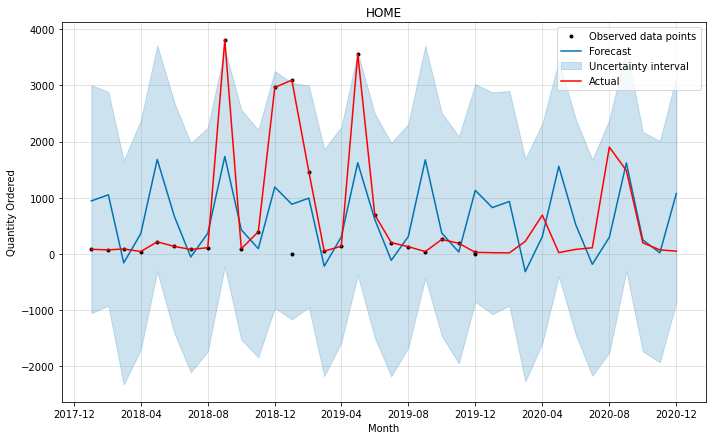

ACCESSORIES


11:43:36 - cmdstanpy - INFO - Chain [1] start processing
11:43:36 - cmdstanpy - INFO - Chain [1] done processing


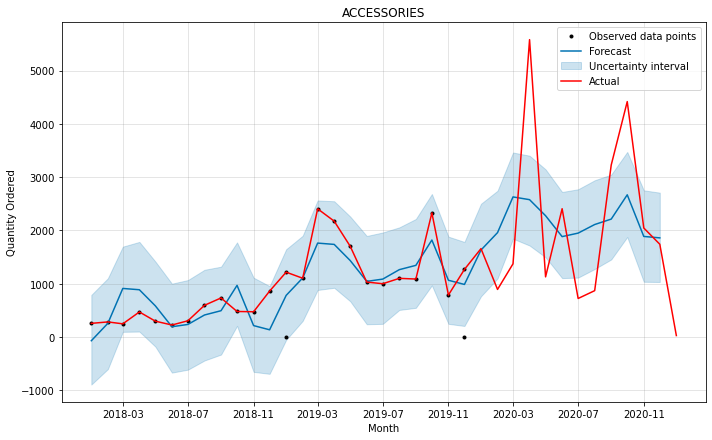

SWIMWEAR


11:43:38 - cmdstanpy - INFO - Chain [1] start processing
11:43:38 - cmdstanpy - INFO - Chain [1] done processing


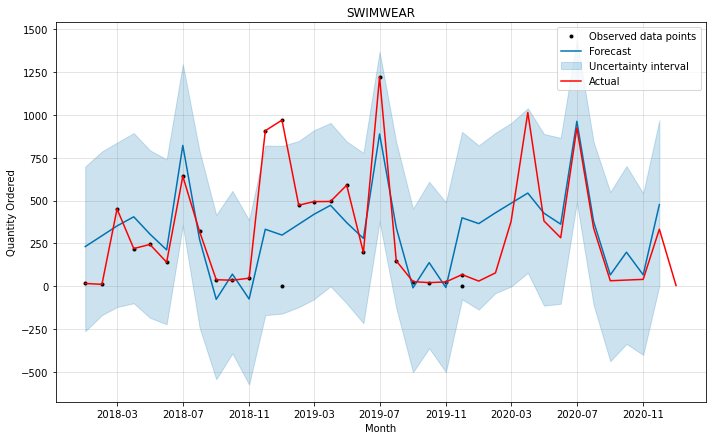

In [19]:
prediction_results_df = pd.DataFrame()
prediction_df = pd.DataFrame()

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    
    df_model = factOrder_df[factOrder_df[article_dimension] == row[article_dimension]]
    df_model = df_model.loc[:, ['DateOrderedKey', 'QuantityOrdered']]
    df_model = df_model.reset_index()
    df_model = df_model[['DateOrderedKey', 'QuantityOrdered']]
    df_model.columns = ['ds', 'y']
    #if df_model.shape[0] < 2:
    #    continue
    
    #df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(str(int(train_end_year) - 1) + '-01-01'), 'y' : 0}])])
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(train_end_year + '-01'), 'y' : 0}])])
    df_model = pd.concat([df_model, pd.DataFrame([{'ds' : pd.to_datetime(train_end_year + '-12'), 'y' : 0}])])
        
    train, test = CreateSplitTestAndTrainData(df_model)
    
    #test = test.groupby(pd.to_datetime(test['ds'], format= '%Y-%m'))['y'].sum().fillna(0)
   # test['ds'] = pd.to_datetime(test['ds'].dt.strftime('%Y-%m-01'))
    #test = test.groupby(test['ds'])['y'].sum().fillna(0)
    #print(test)
    #print(train)
    
    model = CreateModel(train)
    predictions = ModelPrediction(model, row[article_dimension])
    #print(predictions)
    
    prediction_temp_df = predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-12:]    
    
    df_model_performance = pd.merge(test, prediction_temp_df, on='ds') #, how='right')
    
    df_model_performance[article_dimension] = row[article_dimension]
    prediction_temp_df[article_dimension] = row[article_dimension]
    
    #print(df_model_performance)    
    #print(test)
    #print(predictions)
    #print(df_model_performance)
    
    prediction_results_df = pd.concat([prediction_results_df, df_model_performance]) 
    prediction_df = pd.concat([prediction_df, prediction_temp_df]) 
    
    
    #df_model_cv = cross_validation(model, initial='365.25 days', period='180 days', horizon = '365.25 days')        
    #df_model_performance = performance_metrics(df_model_cv)
    
    #df_model_performance[article_dimension] = row[article_dimension]
    #prediction_results_df = pd.concat([prediction_results_df, df_model_performance])  
    

In [20]:
model.component_modes

{'additive': ['monthly',
  'additive_terms',
  'extra_regressors_additive',
  'holidays'],
 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}

In [21]:
prediction_results_df = prediction_results_df.round(2)
prediction_results_df.fillna(0, inplace=True)

prediction_df = prediction_df.round(2)
prediction_df.fillna(0, inplace=True)

In [22]:
#prediction_results_df.set_index('ds', inplace=True)

#prediction_results_df['Month'] = prediction_results_df['ds'] #.dt.strftime('%Y-%m')

# Group by month and aggregate the values
prediction_month_df = prediction_df.groupby(['ds', article_dimension])['yhat'].sum().reset_index()

prediction_month_df['ds'] = prediction_month_df['ds'].dt.strftime('%B')

# Group by month and pivot the data
prediction_month_df = prediction_month_df.pivot(index = article_dimension, columns='ds', values='yhat')

#print(prediction_results_month_df.columns)
# Rename the columns to display month
#prediction_results_month_df.columns = prediction_results_month_df.columns.Month.strftime('%B')

# Fill NaN values with 0
prediction_month_df.fillna(0, inplace=True)

# Define the desired month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

prediction_month_df.columns = pd.Categorical(prediction_month_df.columns, categories=month_order, ordered=True)

# Sort the dataframe columns based on the custom order
prediction_month_df = prediction_month_df.sort_index(axis=1)

print(prediction_month_df)

                  January  February    March    April      May     June  \
ArticleGroupName                                                          
ACCESSORIES       1632.33   1959.38  2629.59  2577.97  2276.56  1884.39   
BODY AND ONESIE    641.10    439.52   322.38   152.30   708.18  1214.43   
BOTTOMS           2332.58   1982.45   680.21   216.68  2671.25  3166.51   
DRESSES           1500.08   1514.77   424.45   388.59  2190.96  2027.07   
HATS               683.27   1164.25   479.20   892.23  2442.09  1239.34   
HOME               824.31    933.57  -317.48   307.71  1559.46   516.45   
OUTERWEAR          729.98    709.32   887.86   688.36   941.53  1453.38   
SWIMWEAR           365.68    428.71   484.64   543.90   426.34   362.51   
TOPS              3160.91   2934.75  2515.57  1845.55  4662.55  6471.82   

                     July   August  September  October  November  December  
ArticleGroupName                                                            
ACCESSORIES       19

In [23]:
#prediction_results_df[prediction_results_df[article_dimension] == 'BABY KIT']
#prediction_results_df[12:36]

In [24]:
# Calculate MSE value
model_performance_MSE = mean_squared_error(prediction_results_df['y'], prediction_results_df['yhat'])
print('The MSE for the Prophet model is', model_performance_MSE)

# Calculate RMSE value
model_performance_RMSE = np.sqrt(model_performance_MSE)
print('The RMSE for the Prophet model is', model_performance_RMSE)

# Calculate MAE value
model_performance_MAE = mean_absolute_error(prediction_results_df['y'], prediction_results_df['yhat'])
print(f'The MAE for the Prophet model is', model_performance_MAE)

# Calculate MAPE value
model_performance_APE = np.abs((prediction_results_df['y'] - prediction_results_df['yhat']) / prediction_results_df['y'])
#model_performance_MAPE = np.mean(model_performance_APE)
#print(f'The MAPE for the Prophet model is', model_performance_MAPE)

model_performance_MAPE = mean_absolute_percentage_error(prediction_results_df['y'], prediction_results_df['yhat'])
print(f'The MAPE for the Prophet model is', model_performance_MAPE)

# Calculate MAPE value
model_performance_MDAPE = np.median(model_performance_APE)
print(f'The MDAPE for the Prophet model is', model_performance_MDAPE)

The MSE for the Prophet model is 7832051.688480556
The RMSE for the Prophet model is 2798.5802987373
The MAE for the Prophet model is 1462.9697222222226
The MAPE for the Prophet model is 2.4040179262261936
The MDAPE for the Prophet model is 0.5559717911009625


In [25]:
# Model performance by Dimension
model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
model_performance_df.columns = [article_dimension, 'MSE', 'RMSE', 'MAE', 'MAPE', 'MDAPE']

for index, row in article_dimension_df.iterrows():
    print(row[article_dimension])
    prediction_results_temp_df = prediction_results_df[prediction_results_df[article_dimension] == row[article_dimension]]    
    
    if not prediction_results_temp_df.empty:
               
        # Calculate MSE value
        model_performance_MSE = mean_squared_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate RMSE value
        model_performance_RMSE = np.sqrt(model_performance_MSE)

        # Calculate MAE value
        model_performance_MAE = mean_absolute_error(prediction_results_temp_df['y'], prediction_results_temp_df['yhat'])

        # Calculate MAPE value
        model_performance_APE = np.abs((prediction_results_temp_df['y'] - prediction_results_temp_df['yhat']) / prediction_results_temp_df['y'])
        model_performance_MAPE = np.mean(model_performance_APE)

        # Calculate MDAPE value
        model_performance_MDAPE = np.median(model_performance_APE)

        new_record = {article_dimension : row[article_dimension], 'MSE' : model_performance_MSE, 'RMSE' : model_performance_RMSE,
        'MAE' : model_performance_MAE, 'MAPE' : model_performance_MAPE, 'MDAPE' : model_performance_MDAPE}

        #new_records.append(new_record)

        model_performance_df = model_performance_df.append(new_record, ignore_index = True)

TOPS
BOTTOMS
DRESSES
OUTERWEAR
HATS
BODY AND ONESIE
HOME
ACCESSORIES
SWIMWEAR


C:\Users\Sandeep\AppData\Local\Temp\ipykernel_3856\2936530940.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  model_performance_df = pd.DataFrame(pd.np.empty((0, 6)))
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_3856\2936530940.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_3856\2936530940.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_performance_df = model_performance_df.append(new_record, ignore_index = True)
C:\Users\Sandeep\AppData\Local\Temp\ipykernel_3856\2936530940.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a futu

In [26]:
model_performance_df

,ArticleGroupName,MSE,RMSE,MAE,MAPE,MDAPE
0,TOPS,3.704434e+07,6086.406562,3894.746667,0.398486,0.341721
1,BOTTOMS,1.295591e+07,3599.431853,2492.395000,0.558086,0.567426
2,DRESSES,8.135372e+06,2852.257295,1520.082500,0.569970,0.505903
3,OUTERWEAR,3.691249e+06,1921.262458,1370.375833,0.484227,0.555314
4,HATS,5.539260e+06,2353.563332,1441.934167,0.622909,0.566794
5,BODY AND ONESIE,6.841943e+05,827.160382,601.452500,0.547462,0.559420
6,HOME,6.848857e+05,827.578191,648.425000,15.826520,2.562022
7,ACCESSORIES,1.709169e+06,1307.352005,1044.690000,0.656428,0.467093
8,SWIMWEAR,4.408001e+04,209.952401,152.625833,1.972071,0.447159


In [27]:
#model_performance_df.to_csv('model_performance_df.csv', index=False)
#prediction_results_df.to_csv('prediction_results_df.csv', index=False)

In [28]:
#model_performance_df[model_performance_df[article_dimension] == 'BABY BOOTS']
prediction_results_df[prediction_results_df[article_dimension] == 'BODY AND ONESE']    

,ds,y,yhat,yhat_lower,yhat_upper,ArticleGroupName
